In [7]:
import pandas as pd 
import imblearn

In [8]:
# Open the file csv
data = pd.read_csv('data_updated.csv')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Seleccionar variables relevantes
features = ['Line', 'Incident', 'Day', 'Time']
target_classification = (data['Min Delay'] > 15).astype(int)  # 1 si el retraso es significativo
target_regression = data['Min Delay']

# Codificar variables categóricas
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(data[features])

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_class, y_test_class = train_test_split(X_encoded, target_classification, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_encoded, target_regression, test_size=0.2, random_state=42)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Entrenar modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_class)

# Predicciones y evaluación
y_pred_class = clf.predict(X_test)
print("Reporte de Clasificación:\n", classification_report(y_test_class, y_pred_class))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1759
           1       0.58      0.31      0.41       459

    accuracy                           0.81      2218
   macro avg       0.71      0.63      0.65      2218
weighted avg       0.79      0.81      0.79      2218



# Clasificación (Random Forest):
1) Rendimiento general:

- Precisión global (accuracy): 81%.
- Buen rendimiento al predecir la clase mayoritaria (sin retrasos significativos, clase 0).
- Dificultad al predecir la clase minoritaria (1, retrasos significativos):
- Precision: 58%.
- Recall: 31% (muestra que el modelo no está capturando suficientes casos de retrasos significativos).

2) Posibles problemas:
- Clase minoritaria está desbalanceada (459 casos frente a 1759 de la clase mayoritaria).
- El modelo favorece la clase mayoritaria, lo cual reduce el recall para los retrasos significativos.


In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Entrenar modelo
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train_reg, y_train_reg)

# Predicciones y evaluación
y_pred_reg = xgb.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"RMSE en el conjunto de prueba: {rmse}")


RMSE en el conjunto de prueba: 42.24836171809791


# Regresión (XGBoost):
1) Rendimiento general:
- RMSE: 42.25 minutos, lo que significa que en promedio el error en las predicciones es de 42 minutos.
- Este valor es relativamente alto, posiblemente debido a:
- La presencia de outliers en los retrasos (Min Delay tiene valores muy altos que afectan la precisión).
- La necesidad de más características predictoras relevantes.

2) Posibles mejoras:
- Manejo de outliers para reducir el impacto en el RMSE.
- Agregar características adicionales o transformar las existentes (por ejemplo, interacción entre Line e Incident).

Implementación de mejoras:
1. Clasificación: Manejo de desbalance
2. Regresión: Manejo de outliers


In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)

# Reentrenar modelo con datos balanceados
clf_balanced = RandomForestClassifier(random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluar
y_pred_balanced = clf_balanced.predict(X_test)
print("Reporte de Clasificación con SMOTE:\n", classification_report(y_test_class, y_pred_balanced))


Reporte de Clasificación con SMOTE:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1759
           1       0.57      0.36      0.44       459

    accuracy                           0.81      2218
   macro avg       0.71      0.65      0.66      2218
weighted avg       0.79      0.81      0.80      2218



In [13]:
# Filtrar valores extremos en 'Min Delay'
q1 = data['Min Delay'].quantile(0.25)
q3 = data['Min Delay'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data_filtered = data[(data['Min Delay'] >= lower_bound) & (data['Min Delay'] <= upper_bound)]

# Volver a dividir los datos para la regresión
X_train_reg_filt, X_test_reg_filt, y_train_reg_filt, y_test_reg_filt = train_test_split(
    encoder.transform(data_filtered[features]), data_filtered['Min Delay'], test_size=0.2, random_state=42
)

# Reentrenar modelo
xgb_filt = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_filt.fit(X_train_reg_filt, y_train_reg_filt)

# Evaluar
y_pred_reg_filt = xgb_filt.predict(X_test_reg_filt)
rmse_filt = np.sqrt(mean_squared_error(y_test_reg_filt, y_pred_reg_filt))
print(f"RMSE después de filtrar outliers: {rmse_filt}")


RMSE después de filtrar outliers: 4.695083070084114


In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir el modelo
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Definir los hiperparámetros para buscar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Realizar la búsqueda de hiperparámetros
grid_search_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search_clf.fit(X_train_balanced, y_train_balanced)

# Mejor modelo
best_clf = grid_search_clf.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_best_clf = best_clf.predict(X_test)
print("Mejores hiperparámetros para clasificación:", grid_search_clf.best_params_)
print("\nReporte de Clasificación con XGBoost Optimizado:\n", classification_report(y_test_class, y_pred_best_clf))


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/enriquegomeztagle/anaconda3/envs/ML/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [14:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

Mejores hiperparámetros para clasificación: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Reporte de Clasificación con XGBoost Optimizado:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      1759
           1       0.50      0.48      0.49       459

    accuracy                           0.79      2218
   macro avg       0.69      0.68      0.68      2218
weighted avg       0.79      0.79      0.79      2218



In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir el modelo
xgb_reg = XGBRegressor(random_state=42)

# Definir los hiperparámetros para buscar
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Realizar la búsqueda de hiperparámetros
grid_search_reg = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_reg, scoring='neg_root_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search_reg.fit(X_train_reg, y_train_reg)

# Mejor modelo
best_reg = grid_search_reg.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_best_reg = best_reg.predict(X_test_reg)
rmse_best_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_best_reg))
print("Mejores hiperparámetros para regresión:", grid_search_reg.best_params_)
print(f"RMSE con XGBoost Optimizado: {rmse_best_reg}")


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejores hiperparámetros para regresión: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
RMSE con XGBoost Optimizado: 42.34826741137235


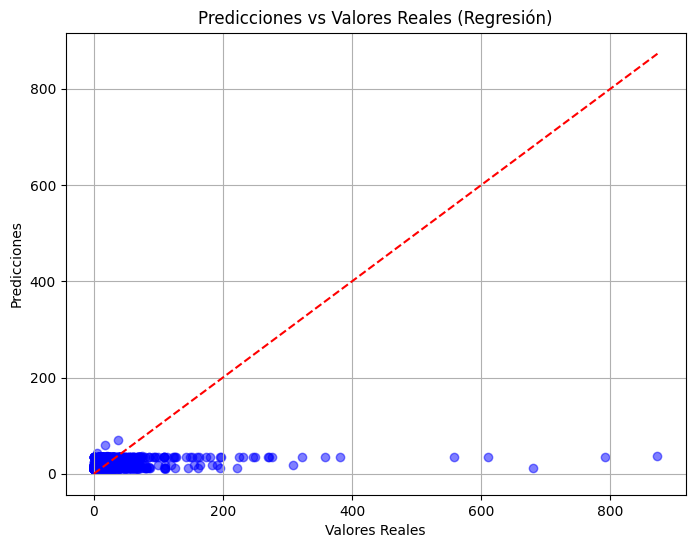

In [18]:
# Graficar predicciones vs valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_best_reg, alpha=0.5, color='blue')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], color='red', linestyle='--')
plt.title('Predicciones vs Valores Reales (Regresión)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid()
plt.show()
